# Building coilsPy from scratch 

## Step 1: Normalized Generation Scheme
First we need a reliable way of generating a tensor of complex numbers that sum to be some specified point along the complex unit circle. To help, let's use a simple function to plot out complex tensors tip-to-tail to ensure they meet this criteria.

In [1016]:
import matplotlib.pyplot as plt
import numpy as np

def plot_complex_vectors(complex_array):
    # Plot the unit circle
    angles = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(angles), np.sin(angles), linestyle='dotted')

    # Starting point for the vectors
    start = 0 + 0j
    for z in complex_array:
        # Plot each vector
        end = start + z
        plt.arrow(start.real, start.imag, z.real, z.imag,
                  head_width=0.05, head_length=0.05, length_includes_head=True)
        start = end

    # Set equal scaling and labels
    plt.axis('equal')
    plt.xlabel('Real')
    plt.ylabel('Imaginary')
    plt.grid(True)
    plt.title('Complex Vectors Summation')

    # Show the plot
    plt.show()

## Create Kernels

For creating dirichlet distributions we will introduce some kernel options.

There are a number of ways I can accomplish our needs, but currently I am using the following approach:

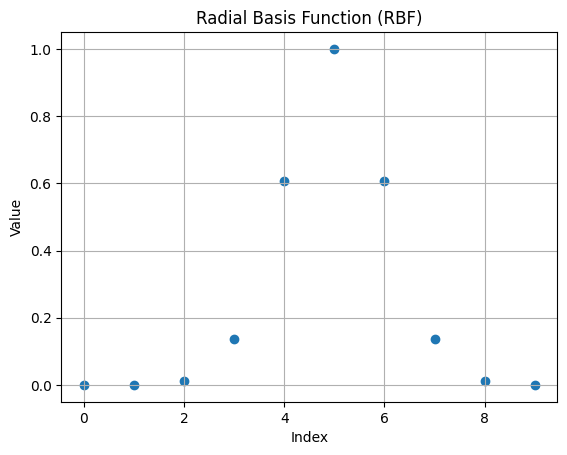

In [1017]:
import torch

def generate_rbf(length, center_index, sigma):
    """
    Generates a 1D radial basis function (Gaussian) of specified width centered on a given index.

    Parameters:
    length (int): The length of the output tensor.
    center_index (int): The index at which the RBF is centered.
    sigma (float): The standard deviation (width) of the RBF.

    Returns:
    torch.Tensor: A 1D tensor representing the radial basis function.
    """
    if center_index >= length or center_index < 0:
        raise ValueError("Center index must be within the range of the tensor length.")

    # Create an array of indices
    x = torch.arange(0, length, dtype=torch.float32)

    # Calculate the RBF
    rbf = torch.exp(-0.5 * ((x - center_index) / sigma) ** 2)

    return rbf

def generate_kernel(length, center_index, type = "rbf", restrictions = [], **kwargs):
    if type == "rbf":
        kernel = generate_rbf(length, center_index, kwargs['sigma'])
        
    # Replace zero values with min_value
    kernel = torch.where(kernel == 0, torch.tensor(1e-10, dtype=kernel.dtype), kernel)
    
    # Set restrictions to 0
    kernel[restrictions] = 1e-10
    
    return kernel


# Example usage
length = 10  # Length of the tensor
center_index = 5  # Center the RBF at index 5
sigma = 1  # Standard deviation of the RBF

rbf_tensor = generate_kernel(length, center_index, type = "rbf", sigma=sigma)

# Plotting the RBF
plt.scatter(torch.arange(length), rbf_tensor)
plt.title("Radial Basis Function (RBF)")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True)
plt.show()

In [1018]:
def rescale_array_to_target_torch(tensor, target_sum):
    # Create a mask for non-zero elements
    non_zero_mask = tensor > 1e-5

    # Calculate the sum of non-zero elements
    sum_non_zero = torch.sum(tensor[non_zero_mask])

    # Count the non-zero elements
    count_non_zero = torch.sum(non_zero_mask)
    
    # Avoid division by zero in case all elements are zero
    if count_non_zero == 0:
        return tensor

    # Calculate the required adjustment to reach the target sum
    adjustment = (target_sum - sum_non_zero) / count_non_zero
    
    # Add the adjustment to each non-zero element
    tensor[non_zero_mask] += adjustment

    return tensor

In [1019]:
torch.distributions.Dirichlet(torch.tensor([5.1, 0.5])).sample()

tensor([0.9310, 0.0690])

C:\Users\johnm\AppData\Local\Temp\ipykernel_19000\2512545771.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rotated_complex_numbers = torch.tensor(rotated_complex_numbers, dtype=torch.complex128)


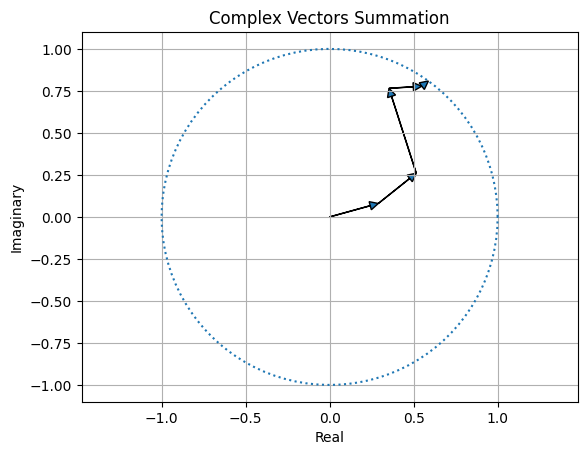

In [1020]:
import torch

def dirichlet_to_goal(goal_value, num_elements, center_index, sigma, magnitude, restrictions):
    # Generate alphas for dirichlet
    alphas = generate_kernel(length = num_elements, center_index = center_index, type = "rbf", sigma = sigma, restrictions = restrictions) * magnitude
    rand_samples = torch.distributions.Dirichlet(alphas).sample()
    
    rand_samples = rescale_array_to_target_torch(rand_samples, goal_value)
    
    return rand_samples

def generate_complex_sum(goal_theta, num_elements, center_index_re, center_index_im, sigma_re, sigma_im, magnitude_re, magnitude_im, restrictions = []):
    real_goal = torch.cos(goal_theta)
    imag_goal = torch.sin(goal_theta)
    real_parts = dirichlet_to_goal(1, num_elements, center_index_re, sigma_re, magnitude_re, restrictions)
    imag_parts = dirichlet_to_goal(0, num_elements, center_index_im, sigma_im, magnitude_im, restrictions)
    complex_numbers = torch.complex(real_parts, imag_parts)
    
    # Step 4: Rotate the entire set of vectors by the goal theta
    rotated_complex_numbers = complex_numbers * (real_goal + imag_goal * 1j)
    
    rotated_complex_numbers = torch.tensor(rotated_complex_numbers, dtype=torch.complex128)

    return rotated_complex_numbers

# Example usage
theta = torch.tensor([0.3 * torch.pi])  # 90 degrees, should sum to i
complex_array = generate_complex_sum(theta, 
                                     num_elements = 5, 
                                     center_index_re = 0, 
                                     center_index_im = 0, 
                                     sigma_re = 1e100, 
                                     sigma_im = 1e100, 
                                     magnitude_re = 1, 
                                     magnitude_im = 1,
                                     restrictions = [])
plot_complex_vectors(complex_array.numpy())

In [1021]:
dirichlet_to_goal(0, num_elements = 4, center_index=0, sigma=100, magnitude = 1, restrictions = [1,2,3])

tensor([0.0000e+00, 1.1755e-38, 1.1755e-38, 1.1755e-38])

## Renormalization

In theory, the previous steps should ensure conservation. However, even when using a precision of complex128, there are still memory errors that cause us to lose conservation. Therefore we can optionally renormalize. 

In [1022]:
def renormalize_to_unit_circle(array):
    """
    Renormalizes an array of complex numbers so that it sums to a point on the unit circle.

    Parameters:
    array (torch.Tensor): A 1D tensor of complex numbers.

    Returns:
    torch.Tensor: A renormalized 1D tensor of complex numbers.
    """
    current_sum = torch.sum(array)
    if current_sum == 0:
        return array  # Avoid division by zero if the current sum is 0

    # Calculate the magnitude of the current sum
    magnitude = torch.abs(current_sum)

    # Calculate the scale factor
    scale_factor = 1 / magnitude

    # Renormalize the array
    renormalized_array = array * scale_factor

    return renormalized_array
    

## Initial State Generation

This function alone is sufficient for generating our initial state, so let's make some helper functions to generate our initial transition tensor and interaction tensor. 

In [1023]:
# Transition tensor create:
def initialize_transition_tensor(num_elements, theta, restrict_dict = []):
    # Create a list to store each column
    columns = []
    num_columns = num_elements

    for col in range(num_columns):
        
        if col in restrict_dict:
            restrictions = restrict_dict[col]
        else:
            restrictions = []
                    
        column = generate_complex_sum(theta, 
                    num_elements = num_elements, 
                    center_index_re = col, 
                    center_index_im = 0, 
                    sigma_re = torch.rand(1)[0]*0.3 + 0.2, 
                    sigma_im = 1e10, 
                    magnitude_re = 1.0, 
                    magnitude_im = 1e5,
                    restrictions = restrictions)
        columns.append(column.unsqueeze(1))  # Add a dimension to make it a column

    # Combine columns into a matrix
    transition_tensor = torch.cat(columns, dim=1)
    
    return transition_tensor

In [1024]:
# Interaction Tensor Create:
def initialize_interaction_tensor(num_elements, theta, restrict_dict = []):
    # Example usage
    num_3d_tensors = num_elements + 1  # Number of 3D tensors in the 4D tensor
    num_matrices = num_elements  # Number of 2D matrices in each 3D tensor
    num_columns = num_elements  # Number of columns in each 2D matrix

    # Create a list to store each 3D tensor
    tensors_3d = []

    for _ in range(num_3d_tensors):
        matrices = []
        for _ in range(num_matrices):
            columns = []
            for col in range(num_columns):
                
                if col in restrict_dict:
                    restrictions = restrict_dict[col]
                else:
                    restrictions = []
                    
                column = generate_complex_sum(theta, 
                                    num_elements = num_elements, 
                                    center_index_re = col, 
                                    center_index_im = 0, 
                                    sigma_re = torch.rand(1)[0]*0.3 + 0.2, 
                                    sigma_im = 1e10, 
                                    magnitude_re = 1.0, 
                                    magnitude_im = 1e5,
                                    restrictions = restrictions)
                columns.append(column.unsqueeze(1))  # Add a dimension to make it a column
            matrix = torch.cat(columns, dim=1)
            matrices.append(matrix)  # Add a dimension to make it a 2D matrix
        tensor_3d = torch.stack(matrices, dim=2)
        tensors_3d.append(tensor_3d)

    # Combine 3D tensors into a 4D tensor
    # Stack along the fourth dimension
    interaction_tensor = torch.stack(tensors_3d, dim=3)
    
    return interaction_tensor

Now we can generate all the starting states:

In [1025]:
num_elements = 5

# Thetas for state, transition, and interactions
angles_dict = {
    'state': 0.3,
    'transition': 0.2,
    'interaction': 0.4
}

# Set restrictions

# Local
# restrict_dict = {
#     0: [2, 3, 4],
#     1: [3, 4],
#     2: [0, 4],
#     3: [0, 1],
#     4: [0, 1, 2]
# }

# Grouping
# restrict_dict = {
#     0: [2, 3, 4],
#     1: [2, 3, 4],
#     2: [0, 1],
#     3: [0, 1],
#     4: [0, 1]
# }

# No restrictions
restrict_dict = {}

thetas_dict = {key : torch.tensor([value * torch.pi]) for key, value in angles_dict.items()}

# Establish state_tensor
state_tensor = generate_complex_sum(thetas_dict['state'], 
                                     num_elements = num_elements, 
                                     center_index_re = 0, 
                                     center_index_im = 0, 
                                     sigma_re = 1e100, 
                                     sigma_im = 1e100, 
                                     magnitude_re = 1, 
                                     magnitude_im = 100,
                                     restrictions = [])
transition_tensor = initialize_transition_tensor(theta = thetas_dict['transition'], num_elements = num_elements, restrict_dict=restrict_dict)
interaction_tensor = initialize_interaction_tensor(theta = thetas_dict['interaction'], num_elements = num_elements, restrict_dict=restrict_dict)

# Move everything to GPU
# state_tensor = state_tensor.to('cuda:0')
# transition_tensor = transition_tensor.to('cuda:0')
# interaction_tensor = interaction_tensor.to('cuda:0')

state_tensor.device

C:\Users\johnm\AppData\Local\Temp\ipykernel_19000\2512545771.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rotated_complex_numbers = torch.tensor(rotated_complex_numbers, dtype=torch.complex128)


device(type='cpu')

In [1026]:
abs(transition_tensor)

tensor([[1.0000e+00, 7.7918e-05, 2.7813e-04, 1.8868e-04, 1.7676e-04],
        [4.3346e-04, 9.9990e-01, 6.9538e-04, 4.4975e-04, 2.0574e-04],
        [6.8001e-04, 1.5814e-04, 9.9998e-01, 8.7470e-06, 1.6221e-04],
        [2.5253e-04, 6.5126e-04, 7.3875e-04, 1.0000e+00, 4.6280e-04],
        [2.4155e-05, 7.2551e-04, 6.6437e-04, 3.9965e-05, 1.0000e+00]],
       dtype=torch.float64)

In [1027]:
subvec = state_tensor[0] + state_tensor[1]
subvec * torch.conj(subvec)

tensor(0.5706+0.j, dtype=torch.complex128)

In [1028]:
print("CUDA GPU:", torch.cuda.is_available())

CUDA GPU: False


## Normalization testing
Let's first do some quick tests to make sure our normalization is working as intended

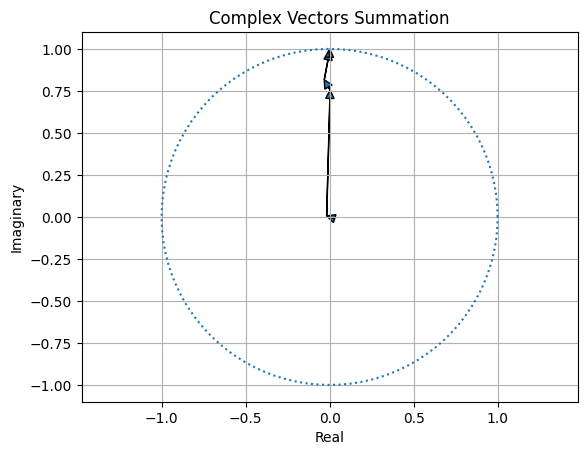

In [1029]:
# First just checking that our initial transition tensor looks good:
new_state_tensor = torch.matmul(transition_tensor,state_tensor)

plot_complex_vectors(new_state_tensor.to('cpu').numpy())

tensor([[-3.0919e-01+9.5100e-01j,  1.2117e-04+3.9053e-05j,
          2.3386e-04+7.5431e-05j,  3.2724e-04+1.0686e-04j,
         -1.3141e-04-4.3020e-05j],
        [-4.3078e-04-1.4065e-04j, -3.0824e-01+9.5131e-01j,
          1.3345e-04+4.8839e-04j,  7.5000e-04+2.4279e-04j,
         -2.4423e-06-1.5058e-07j],
        [-2.2055e-04-7.1432e-05j,  9.0479e-04+2.9528e-04j,
         -3.1668e-03+1.0839e-02j,  2.1259e-05+7.3467e-06j,
         -1.9848e-04-6.5119e-05j],
        [ 3.2346e-04+1.0515e-04j, -7.5266e-04-2.4531e-04j,
         -3.0665e-01+9.3951e-01j, -3.0973e-01+9.5082e-01j,
          6.1775e-05+2.0408e-05j],
        [ 5.0165e-04+1.6388e-04j, -1.0469e-03-3.4083e-04j,
          4.3393e-04+1.4148e-04j, -3.8530e-04-1.2531e-04j,
         -3.0875e-01+9.5114e-01j]], dtype=torch.complex128)


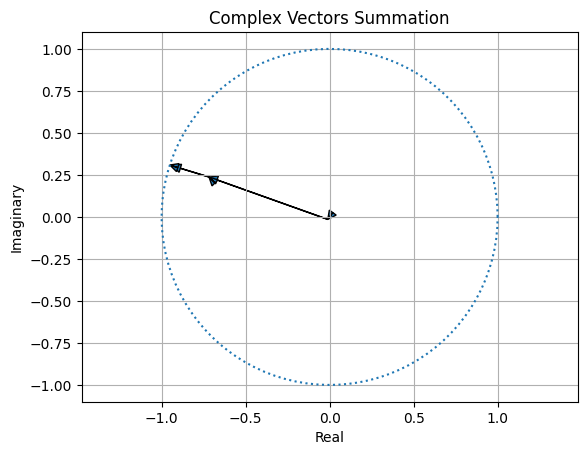

In [1030]:
# Now we check that our interaction tensor works as intended
sel_state = 1

if sel_state == 0:
    selected_normalized_tensor = state_tensor
else:
    selected_normalized_tensor = transition_tensor[:,sel_state-1]
    
selected_interaction_tensor = interaction_tensor[:,:,:,sel_state]

new_transition_tensor = torch.matmul(selected_interaction_tensor, selected_normalized_tensor)

print(new_transition_tensor)

new_state_tensor = torch.matmul(new_transition_tensor, state_tensor)

plot_complex_vectors(new_state_tensor.to('cpu').numpy())

In [1031]:
check = torch.matmul(selected_interaction_tensor, selected_normalized_tensor)[:,1]
sum(check * torch.conj(sum(check)))

tensor(1.0000-1.6480e-17j, dtype=torch.complex128)

In [1032]:
check = selected_interaction_tensor[:,:,1]
sum(check * torch.conj(sum(check)))

tensor([1.0000+1.8215e-17j, 1.0000-2.6075e-17j, 1.0000+2.7539e-17j,
        1.0000+4.7705e-17j, 1.0000-4.0332e-17j], dtype=torch.complex128)

In [1033]:
def complex_add(tensor):
    return torch.abs(torch.real(tensor)+torch.imag(tensor))

complex_add(torch.complex(torch.tensor([5.0, 3.0]), torch.tensor([-2.0, 2.0])))

tensor([3., 5.])

Now that this is workign as intended, let's make our function to select the normalized subgroup and associated transition matrix that will maximize the probability from going from the largest state to the smallest state. 

In [1034]:
def select_transition_tensor(state_tensor,transition_tensor,interaction_tensor, use_abs = False):
    if use_abs:
        sum_select = torch.abs
    else:
        sum_select = complex_add
    
    # First we need to know which transition point we are looking for
    state_magnitudes = sum_select(state_tensor)
    state_magnitudes_order = torch.argsort(state_magnitudes)
    to_index = state_magnitudes_order[0] # The smallest state magnitude
    from_index = state_magnitudes_order[-1] # The largest state magnitude
    
    # Next we need to go through each possible normalized subgroup and determine which one we should use
    new_transitions = []
    for sel_state in range(state_tensor.shape[0]):
        if sel_state == 0:
            selected_normalized_tensor = state_tensor
        else:
            selected_normalized_tensor = transition_tensor[:,sel_state-1]
            
        selected_interaction_tensor = interaction_tensor[:,:,:,sel_state]

        new_transition_tensor = torch.matmul(selected_interaction_tensor,selected_normalized_tensor)
        
        new_transitions.append(new_transition_tensor)
        
     # Convert list of tensors to a tensor
    new_transitions_tensor = torch.stack(new_transitions)
    
    sorted_indices = torch.argsort(sum_select(new_transitions_tensor[:, to_index, from_index]), descending=True)
    selected_subgroup = sorted_indices[0]
    
    return new_transitions[selected_subgroup], selected_subgroup

select_transition_tensor(state_tensor,transition_tensor,interaction_tensor)

(tensor([[-3.0913e-01+9.5102e-01j, -1.3190e-03-4.2896e-04j,
           1.0264e-04+3.3008e-05j,  2.9987e-04+9.7739e-05j,
          -1.1761e-03-3.8086e-04j],
         [ 2.1878e-04+7.0900e-05j, -3.0935e-01+9.5095e-01j,
           3.3114e-04+1.0866e-04j, -2.9782e-04-9.6204e-05j,
           3.0070e-04+9.7228e-05j],
         [ 5.2826e-04+1.7172e-04j,  8.1010e-04+2.6392e-04j,
          -9.5914e-02+2.9199e-01j, -1.4797e-04-4.8386e-05j,
          -1.8615e-05-6.0930e-06j],
         [-1.0690e-03-3.4678e-04j,  3.3757e-05+1.0587e-05j,
          -2.1342e-01+6.5896e-01j, -3.0865e-01+9.5118e-01j,
           3.4536e-04+1.8547e-04j],
         [ 4.3225e-04+1.4007e-04j,  8.1096e-04+2.6296e-04j,
          -1.1826e-04-3.8914e-05j, -2.2162e-04-7.3115e-05j,
          -3.0847e-01+9.5116e-01j]], dtype=torch.complex128),
 tensor(2))

Finally we just need to step through the coil

In [1035]:
import time

tic = time.time()

num_steps = 10_000
prob_save = []

print(f"substate starting total: {sum(torch.real(state_tensor * torch.conj(state_tensor.sum()))[:2])}")
for i_step in range(num_steps):
    transition_tensor, selected_subgroup = select_transition_tensor(state_tensor,transition_tensor,interaction_tensor, use_abs = False)
    
    state_tensor = torch.matmul(transition_tensor,state_tensor)
    
    #plot_complex_vectors(state_tensor.to('cpu').numpy())
    
    # Optionally we can renomalize to avoid memory errors
    state_tensor = renormalize_to_unit_circle(state_tensor)
    
    state_prob = torch.real(state_tensor * torch.conj(state_tensor.sum()))
    
    prob_save.append(state_prob)
    
    #print(state_prob[0]+state_prob[1])
    #print(state_prob.sum())
    # print(selected_subgroup)
    
    #plot_complex_vectors(state_tensor.to('cpu').numpy())
    
toc = time.time()    
print(f"substate ending total: {sum(torch.real(state_tensor * torch.conj(state_tensor.sum()))[:2])}")

print(f"Processing time: {round(toc-tic,4)}s")
print(state_prob.sum())

substate starting total: 0.7554006754022649
substate ending total: 0.7555504803112181
Processing time: 0.0315s
tensor(1., dtype=torch.float64)


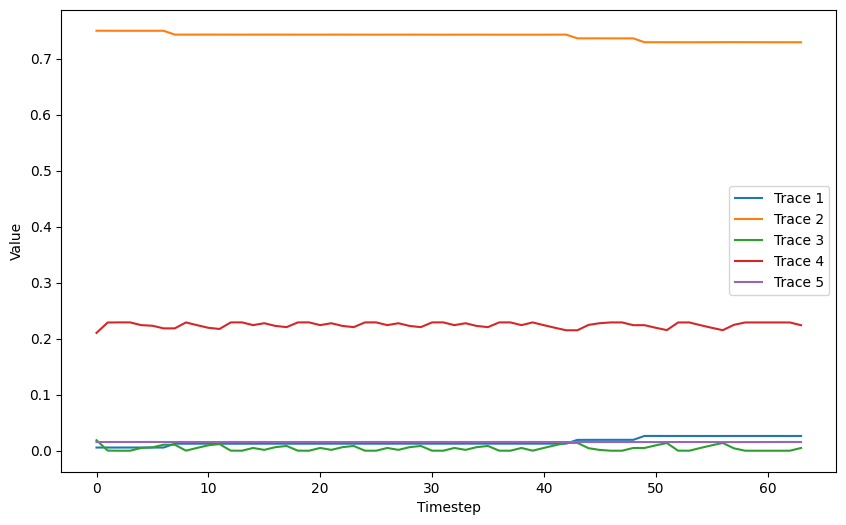

In [1036]:
# Your data
data = [row.to('cpu') for row in prob_save]
# Transpose the data to get 5 traces
traces = list(zip(*data))

# Plotting
plt.figure(figsize=(10, 6))
for i, trace in enumerate(traces):
    plt.plot(trace, label=f'Trace {i+1}')

plt.xlabel('Timestep')
plt.ylabel('Value')
plt.legend()
plt.show()

In [1037]:
transition_tensor.shape

torch.Size([5, 5])

In [1038]:
state_tensor.shape

torch.Size([5])

In [1039]:
interaction_tensor.shape

torch.Size([5, 5, 5, 6])

In [1040]:
# Example tensors
A = torch.rand(5, 5)  # Tensor A of size (5, 5)
B = torch.rand(5)    # Tensor B of size (5,)

# Reshape B to make it a column tensor of size (5, 1)
B = B.view(-1, 1)  # or B.unsqueeze(1)

# Concatenate B (as the first column) and A
result = torch.cat((B, A), dim=1)

print(result)
print(result.shape)  # Should print torch.Size([5, 6])

tensor([[0.7843, 0.4732, 0.5396, 0.0596, 0.2204, 0.6366],
        [0.0942, 0.5350, 0.5693, 0.8304, 0.9320, 0.8316],
        [0.0549, 0.0208, 0.0509, 0.7788, 0.6186, 0.5962],
        [0.8177, 0.4873, 0.3544, 0.9615, 0.3723, 0.8267],
        [0.6902, 0.8303, 0.3439, 0.4021, 0.6489, 0.9379]])
torch.Size([5, 6])


In [1041]:
normsubgroup_tensor = torch.cat((state_tensor.view(-1, 1), transition_tensor),dim = 1)
normsubgroup_tensor.shape

torch.Size([5, 6])

In [1042]:
# Example tensors
big_tensor = torch.rand(5, 5, 5, 6)  # Tensor of size [5, 5, 5, 6]
small_tensor = torch.rand(5, 6)     # Tensor of size [5, 6]

# Use torch.einsum for element-wise multiplication and sum over the last dimension
# 'ijkl,jl->ijk' notation means: multiply elements along the 'l' dimension and sum over 'l',
# keeping the 'i', 'j', 'k' dimensions as they are.
result = torch.einsum('ijkl,jl->ijk', big_tensor, small_tensor)

print(result.shape)
# This results in a tensor of shape [5, 5, 5], because it's effectively performing the dot product
# over the last dimension of 'big_tensor' with each corresponding vector in


torch.Size([5, 5, 5])


In [1043]:
result_tensor = torch.zeros(5,5,6)

for i in range(6):
    result_tensor[:,:,i] = torch.matmul(big_tensor[:,:,:,i],small_tensor[:,i])
    
print(result_tensor)

result_einsum = torch.einsum('ijlk,ik->ijk', big_tensor, small_tensor)

#print(result_einsum)


tensor([[[1.1127, 1.1205, 2.0996, 0.8731, 0.6832, 1.2026],
         [1.1367, 1.2561, 1.8458, 1.0645, 0.6841, 2.2737],
         [0.9026, 1.2140, 1.4686, 1.4842, 1.3171, 0.8788],
         [0.6734, 0.4733, 2.6412, 2.0292, 0.9048, 1.0423],
         [1.0959, 1.5158, 1.3522, 0.7899, 1.0281, 1.6580]],

        [[0.5421, 0.4480, 2.0958, 1.2806, 0.8782, 1.8850],
         [1.3388, 1.5322, 1.6402, 1.4655, 0.3952, 1.8218],
         [1.0490, 1.6942, 1.5237, 1.6124, 0.5319, 1.9955],
         [1.3361, 0.5354, 2.0624, 1.8937, 1.4760, 1.5255],
         [1.0540, 0.8833, 2.0487, 1.5559, 1.2043, 1.6281]],

        [[1.3187, 1.1014, 2.5636, 1.5543, 0.6315, 0.7552],
         [0.7164, 0.7319, 1.7774, 1.1978, 1.3737, 2.2249],
         [1.5085, 0.5184, 2.0639, 1.3418, 0.8704, 2.4544],
         [1.2796, 0.9265, 2.0291, 1.2769, 0.9272, 1.5891],
         [0.7631, 0.9475, 1.3625, 0.9207, 0.7026, 2.0939]],

        [[1.3306, 1.3949, 1.5945, 1.4698, 0.6116, 2.3681],
         [1.1141, 0.7395, 2.1485, 1.3916, 0.9751, 

In [1044]:
transition_tensors = torch.matmul(interaction_tensor, normsubgroup_tensor)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (125x6 and 5x6)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SliceSelector(nn.Module):
    def __init__(self, num_slices):
        super(SliceSelector, self).__init__()
        # A simple linear layer to compute importance scores for each slice
        self.importance = nn.Linear(num_slices, num_slices)

    def forward(self, x):
        # Assuming x is of shape [batch_size, height, width, num_slices]
        batch_size, height, width, num_slices = x.shape

        # Flatten the spatial dimensions and compute importance scores
        x_flat = x.view(batch_size, -1, num_slices)  # New shape: [batch_size, height*width, num_slices]
        scores = self.importance(x_flat)  # Computes a score for each slice
        scores = scores.view(batch_size, height, width, num_slices)  # Reshape scores back

        # Apply softmax to get a distribution over slices
        weights = F.softmax(scores, dim=-1)

        # Use the weights to get a weighted sum of the slices, effectively selecting slices based on importance
        # This step aggregates the slices into a single output per position
        selected = torch.einsum('bhwn,bhwi->bhw', weights, x)

        return selected

# Example usage
batch_size = 10
tensor = torch.rand(batch_size, 5, 5, 6)  # Example tensor
model = SliceSelector(num_slices=6)

result = model(tensor)
print(result.shape)  # Should print torch.Size([10, 5, 5]), indicating the selection/aggregation step was performed


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SliceSelector(nn.Module):
    def __init__(self, num_slices):
        super(SliceSelector, self).__init__()
        # Learnable parameters that determine the importance of each slice
        self.logits = nn.Parameter(torch.zeros(num_slices))

    def forward(self, x, temperature=0.5):
        # x is of shape [batch_size, height, width, num_slices]
        batch_size, height, width, num_slices = x.shape

        # Get logits for each slice
        logits = self.logits.unsqueeze(0)  # Adding batch dimension

        # Apply Gumbel-Softmax to approximate a discrete selection of slices
        soft_selection = F.gumbel_softmax(logits, tau=temperature, hard=True, dim=-1)

        # Select slices based on the soft selection
        # This step effectively multiplies each slice by either 0 or 1, heavily favoring one slice
        selected = torch.einsum('bni,bhwj->bhwi', soft_selection, x)

        # Since soft_selection is nearly one-hot, but still differentiable, we "select" mostly one slice
        return selected[:, :, :, 0]  # Only return the selected slice, for all items in the batch

# Example usage
num_slices = 6
tensor = torch.rand(10, 5, 5, num_slices)  # Example tensor with batch dimension
model = SliceSelector(num_slices=num_slices)

selected_slice = model(tensor)
print(selected_slice.shape)  # Should print torch.Size([10, 5, 5])
